In [4]:
import pandas as pd
from pandas.api.types import is_list_like
import pandas_datareader.data as web
from heston import *
import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
prices = pd.DataFrame([])

symbols = ['WIKI/AAPL'] #, 'GOOG', 'MSFT','ZNGA','^VIX']
cols = ['r','b','g','y','c']
for symbol in symbols:
    prices[symbol] = web.DataReader(name=symbol, data_source='quandl', start='2017-7-1')['AdjClose']

prices = prices[::-1]

In [9]:
nInt = 512
r0 = 0.0002

#p0 = [5.76145232379, 0.393696857573, 0.99999999,-0.686387364593,0.685888435264]
#print Error_Function(p0)
S = prices[symbols[0]]
K = 160.0   # set K=130 to get minimun numbers of negative V value
T_0 = 1.0
r = r0
sigma = 0.6
lmbda = 0.1
meanV = 0.1
v0 = 0.1
rho =-0.9
#V= HestonCOS(S,K,T,r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt)
n = len(prices)
V = np.array([0]*n, dtype='float')
T = np.array([0]*n, dtype='float')

start = prices.index[0]

Try fixing time to maturity T

In [10]:
for i in range(n):
    current =prices.index[i]
    T[i]= 1.0 # - (current-start).days/365.0
    V[i]= HestonCOS(S[i],K,T[i],r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt)


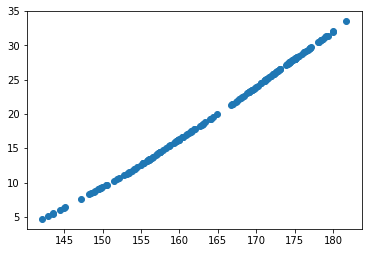

In [11]:
import matplotlib.pyplot as plt

plt.scatter(S, V)

Now vary time to maturity T

In [12]:
for i in range(n):
    current =prices.index[i]
    T[i]= 1.0 - (current-start).days/365.0
    V[i]= max(0, HestonCOS(S[i],K,T[i],r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt))

This needs to be a 3d plot as S and T are being varied.

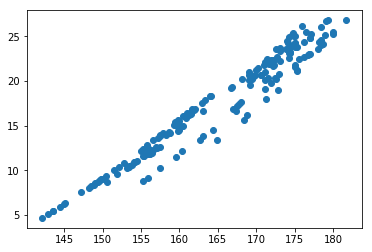

In [15]:
plt.scatter(S, V)

In [16]:
# fit GP
import os
os.environ['TF_C_API_GRAPH_CONSTRUCTION']='0'
import tensorflow as tf
import edward as ed
import matplotlib.pyplot as plt
import numpy as np
from edward.models import Normal
import seaborn as sns
plt.style.use('ggplot')
from edward.models import MultivariateNormalTriL
from edward.util import rbf

/Users/matthewdixon/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [17]:
x = np.arange(((n-1)*2), dtype = 'float32').reshape(n-1,2)
for i in range(1, n):
    x[i-1] = [S[i], T[i]]

r_v = np.zeros(n-1)
for i in range(n-1):
    r_v[i] = np.log(V[i+1]/V[i])
    
#y = np.array(r_v, dtype = 'float32').reshape(n-1,1)

In [19]:
# GP against V
y = np.array(V[1:183], dtype = 'float32').reshape(n-1,1)

In [20]:
sess = ed.get_session()

# change below parameters to see different training results.
training_number = 180
test_number = 150
scaler = 1
noise_term = 1e-2

idx_train = np.linspace(0, len(y)-1, training_number, dtype = 'int')
idx_test = np.linspace(0, len(y)-1, test_number, dtype = 'int')
x_train = np.array(x[idx_train], dtype='float32') * scaler
y_train = np.array(y[idx_train], dtype='float32')#.reshape(training_number, 1)
x_test = np.array(x[idx_test], dtype='float32') * scaler
y_test = np.array(y[idx_test], dtype='float32')#.reshape(test_number, 1)

In [21]:
# mean
Kernel = rbf(x_train).eval()
K_noise = Kernel + np.eye(training_number) * noise_term  
k_s = rbf(x_test, x_train).eval()                   
L = np.linalg.cholesky(K_noise)
alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))
predict_mean = np.dot(k_s, alpha)

# cov
v = np.linalg.solve(L, k_s.T)
var = rbf(x_test).eval() - np.dot(v.T, v)

Date
2017-07-03    142.920109
2017-07-05    143.507725
2017-07-06    142.153221
2017-07-07    143.597361
2017-07-10    144.473805
2017-07-12    145.151057
2017-07-13    147.172854
2017-07-14    148.437722
2017-07-17    148.955620
2017-07-18    149.473519
2017-07-20    149.732468
2017-07-21    149.662751
2017-07-24    151.475396
2017-07-25    152.122770
2017-07-27    149.951579
2017-07-28    148.895863
2017-07-31    148.248489
2017-08-01    149.443640
2017-08-02    156.504989
2017-08-04    155.758020
2017-08-08    159.433108
2017-08-09    160.409148
2017-08-10    155.270000
2017-08-11    157.480000
2017-08-15    161.600000
2017-08-16    160.950000
2017-08-17    157.870000
2017-08-18    157.500000
2017-08-22    159.780000
2017-08-23    159.980000
                 ...    
2018-02-01    167.780000
2018-02-02    160.370000
2018-02-06    163.030000
2018-02-07    159.540000
2018-02-08    155.320000
2018-02-09    155.970000
2018-02-13    164.340000
2018-02-14    167.370000
2018-02-15    172.99

/Users/matthewdixon/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/Users/matthewdixon/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


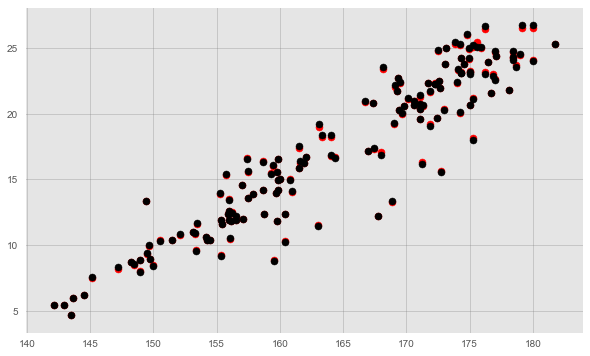

In [30]:
# plot with cov band
up = predict_mean - 2 * (np.sqrt(np.diag(var)))   # 95% confident interval 
down = predict_mean + 2 * (np.sqrt(np.diag(var)))

plt.figure(figsize = (10,6), facecolor='white', edgecolor='white')
#plt.fill_between(up, down, color = 'grey', alpha=0.3)
plt.grid(True, color = 'grey', alpha = 0.3)
plt.scatter(S[idx_test], predict_mean, color = 'r')
plt.scatter(S[idx_test], y_test, color = 'black')

In [31]:
from mpl_toolkits.mplot3d import Axes3D

/Users/matthewdixon/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


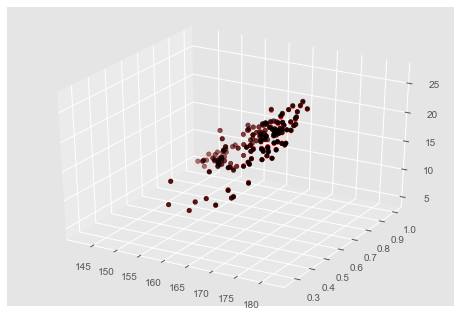

In [46]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(S[idx_test], T[idx_test], y_test, color='black')
ax.scatter(S[idx_test], T[idx_test], predict_mean, color='red')
ax.legend()